# Total return distributions

This notebook shows how to compute stock index statistics.

Import libraries and load data:

In [1]:
import os
import pickle
import scipy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from src.analyzer import StockIndexAnalyzer
from src.analyzer import scipy_fit

# PATH TO DATA
FILEPATH = "data/all_indexes_2006-01-01_2021-12-31.pickle"

with open(FILEPATH, "rb") as f:
    data = pickle.load(f)

START_YEAR = 2006
END_YEAR = 2021

Define groups of indexes:

In [3]:
# Unites States indexes
indexes_usa = ['SPX','CCMP','RIY','RTY','RAY','RLV','RLG','NBI']

# S&P500 sectors
indexes_sp500 = ['S5COND','S5CONS','S5ENRS','S5FINL','S5HLTH','S5INFT','S5MATR','S5TELS','S5UTIL','S5INDU']

# European indexes
indexes_eu = ['DAX','CAC','UKX','BEL20','IBEX','KFX','OMX','SMI']

# Asia Pacific indexes
indexes_apac = ['AS51'] 

# Japan indexes
indexes_jp = ['NKY','TPX']

# BRIC indexes
indexes_bric = ['IBOV','NIFTY','MXIN','SHCOMP','SHSZ300'] 

# All indexes: merge all lists
indexes_all = indexes_usa + indexes_sp500 + indexes_eu + indexes_apac + indexes_jp + indexes_bric

Loop over all indexes to compute empirical statistics (mean, median and mode). The resuts are saved into dictionary.

Processing SPX index


100%|██████████| 500/500 [00:00<00:00, 1049.89it/s]


Total number of stocks: 500
Number of stocks with data between 2006 and 2021 (16 years): 498
Number of stocks with data between 2006 and 2021 with at least doubled price (16 years): 272
Univariate? True
HISTOGRAM MAX 0.89 value = 61 delta = 0.38
Number of bins:  25 Number of data points:  425
Expt Median: 2.369
Expt Mean: 4.259
Expt Mode: 2.772
{'category': 'US', 'years': 16, 'n_stocks_data': 498, 'dmean_ltail': 236.3, 'dmean top 5%': -25.9, 'dmean top 10%': -35.0, 'dmean top 25%': -54.1, 'mean': 4.258760357629433, 'median': 2.3692242065890277, 'mode': 2.771977197719772}


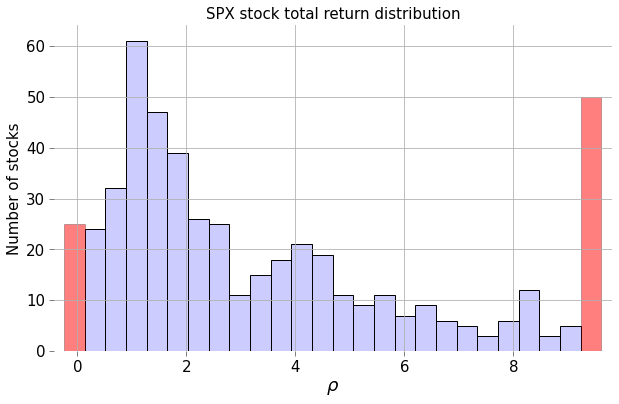

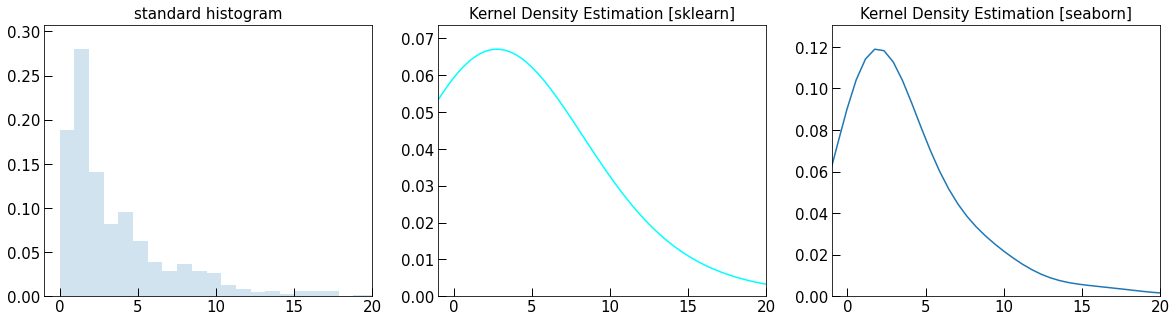

In [5]:
results_expt = {}   # histogram statistics 
results_mcmc = {}   # fit histogram with MCMC
results_scipy = {}  # fit histogram with scipy

results_cumulative = {}

# random seed parametbins = self.bins,er to insure reproducibily of qqplot with seaborn
SEED = 99
np.random.seed(SEED)

for index_name in indexes_all:
    
    print(f"Processing {index_name} index")
    
    # class computes total returns and estimates empirical distribution parameters
    stock_analyzer = StockIndexAnalyzer(prices = data[index_name],
                                        stock_index = index_name,
                                        start_year = START_YEAR,
                                        end_year = END_YEAR)

    # plot empirical histogram with two (left and right) cumulative bins
    stock_analyzer._plot_histogram()
    
    # Part 1. Compute empirical stock index distribution parameter ###
    #stock_analyzer.plot_histogram_fit(save_data=False)

    results_expt[index_name] = stock_analyzer._empirical_distribution_table()

    # TODO:
    # 1. move plot cumulative histogram to analyzer
    # 2. plot_histogram_fit
    # 3. refactor scipy_fit and move it to analyzer
    break

    ##results_scipy[index_name] = stock_analyzer.compare_stats()
    #results_scipy[index_name] = scipy_fit(df=stock_analyzer.mu.copy())
    
    ### Part 2: fit index histogram with MCMC ###
    #results_mcmc[index_name] = stock_analyzer.pymc3_fit(draws=10000, tune=5000)
    
    #summary = stock_analyzer.find_best_distribution()
    ##print(summary)
    #results_mcmc[index_name]['lognorm error'] = summary.loc['lognorm']['sumsquare_error']
    #results_mcmc[index_name]['best distr'] = summary.sort_values('sumsquare_error').iloc[0].name
    #results_mcmc[index_name]['best distr error'] = summary.sort_values('sumsquare_error').iloc[0]['sumsquare_error']
    
    #### Part 3: estimate QQ plot
    #stock_analyzer.plot_qq()
    
    #try:
    #    stock_analyzer.plot_qq_seaborn()
    #except:
    #    continue
    #break

In [ ]:
import matplotlib.pyplot as plt

DIR = 'results/cumulative_plots_'
os.makedirs(DIR, exist_ok=True)

for index_name in results_cumulative.keys():

    fig, ax = plt.subplots()

    results_cumulative[index_name].plot.bar(x='percent_cut_tail', y='contribution', rot=0, color='black', alpha=0.35, ax=ax, label='')

    ax.set_xlim([0,100])
    ax.set_ylim([0,100])

    ax.set_xticks(ticks=[0,25,50,75,100])
    ax.set_xticklabels([0,25,50,75,100])

    ax.set_xlabel("percentage cut", size=15)
    ax.set_ylabel("cumulative contribution",size=15)

    plt.title(f"{index_name} cumulative sum contributions")

    ax.tick_params(direction='in', length=6, width=1.0, colors='black', grid_color='grey', grid_alpha=0.5)
    ax.legend()
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    
    #plt.savefig(f'{DIR}/cumulative_{index_name}.png',bbox_inches='tight')
    break

Transform results dictionary into DataFrame. Transpose the table to have indexes as rows.

In [ ]:
# columns to be rounded
col_dec2 = ['logn mean','logn median','logn mode','logn mu','logn sigma','logn sigma2','C']

df_scipy = pd.DataFrame.from_dict(results_scipy).T
df_scipy[col_dec2] = df_scipy[col_dec2].astype(float).round(2)
df_scipy

In [ ]:
# columns to be rounded
col_dec2 = ['logn mean','logn median','logn mode','logn mu','logn sigma','logn sigma2','C']
col_dec3 = ['muh','sigmah','sigma']
col_dec4 = ['lognorm error', 'best distr error']

df_mcmc = pd.DataFrame.from_dict(results_mcmc).T
df_mcmc = df_mcmc.drop(['muh std','sigma std', 'sigmah std'], axis=1)
df_mcmc[col_dec2] = df_mcmc[col_dec2].astype(float).round(2)
df_mcmc[col_dec3] = df_mcmc[col_dec3].astype(float).round(3)
df_mcmc[col_dec4] = df_mcmc[col_dec4].astype(float).round(4)
df_mcmc

In [ ]:
# columns to be rounded
col_dec = ['mean','mode','median','mean/median','mean/mode']

df_expt = pd.DataFrame.from_dict(results_expt).T
df_expt[col_dec] = df_expt[col_dec].astype(float).round(2)
df_expt

In [ ]:
df_expt.to_latex()

In [ ]:
#df_mcmc.to_latex()

In [ ]:
df_scipy.to_latex()

Save dataframe with the results table into CSV file.

In [ ]:
DIR = 'results'
os.makedirs(DIR, exist_ok=True)

df_expt.to_csv(DIR+f'/data_emprirical_{stock_analyzer.nyears}.csv', header=True)
df_mcmc.to_csv(DIR+f'/data_mcmc_{stock_analyzer.nyears}.csv', header=True)
df_scipy.to_csv(DIR+f'/data_scipy_{stock_analyzer.nyears}.csv', header=True)